<a href="https://colab.research.google.com/github/AmalKhaled28/Sales-Forecasting/blob/main/Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load
train = pd.read_csv('/kaggle/input/walmart-sales-forecast/train.csv', parse_dates=['Date'])
features = pd.read_csv('/kaggle/input/walmart-sales-forecast/features.csv', parse_dates=['Date'])
stores = pd.read_csv('/kaggle/input/walmart-sales-forecast/stores.csv')

# Merge
df = train.merge(features, on=['Store','Date','IsHoliday'], how='left') \
          .merge(stores, on='Store', how='left')

In [ ]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221


 # EXPLORATORY DATA ANALYSIS (EDA)

# Basic dataset info

In [ ]:
df.shape

(421570, 16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

In [ ]:
df.describe(include='all')

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
count,421570.000000,421570.000000,421570,421570.000000,421570,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570,421570.000000
unique,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN
top,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN
freq,NaN,NaN,NaN,NaN,391909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,215478,NaN
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123,NaN,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,NaN,136727.915739
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,NaN,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,NaN,34875.000000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000,NaN,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,NaN,93638.000000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000,NaN,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,NaN,140167.000000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500,NaN,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,NaN,202505.000000
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000,NaN,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,NaN,219622.000000


# Check for duplicates and missing values

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

# Data Processing & Cleaning


In [ ]:
# Handle missing values in MarkDown columns - fill with 0 (assuming no promotion)
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df[markdown_cols] = df[markdown_cols].fillna(0)

In [ ]:
# Convert boolean to integer for modeling
df['IsHoliday'] = df['IsHoliday'].astype(int)

In [ ]:
# Encode store type
df['Type'] = LabelEncoder().fit_transform(df['Type'])

In [ ]:
# Sort data for time series operations
df = df.sort_values(['Store', 'Dept', 'Date']).reset_index(drop=True)

# Feature Engineering

In [ ]:
#Create time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['DayOfYear'] = df['Date'].dt.dayofyear
# Is it the weekend?
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
# Quarterly
df['Quarter'] = df['Date'].dt.quarter

In [ ]:
# Create discount & store size features
df['Total_MarkDown'] = df[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].sum(axis=1)
df['Has_MarkDown'] = (df['Total_MarkDown'] > 0).astype(int)
df['Log_Size'] = np.log1p(df['Size'])

In [ ]:
# LAG FEATURES
# create new columns with previous weeks' sales
# last 1,2,3,4 weeks
df['Sales_Lag_1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
df['Sales_Lag_2'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)
df['Sales_Lag_3'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(3)
df['Sales_Lag_4'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(4)
df['Sales_Lag_52'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(52) # same week last year


In [ ]:
# ROLLING FEATURES
# create columns with average sales over past weeks
rolling_windows = [3, 4, 8]  # last 3, 4, 8 weeks average
for window in rolling_windows:
    df[f'Rolling_{window}'] = df.groupby(['Store', 'Dept'])['Weekly_Sales']\
                                .transform(lambda x: x.rolling(window).mean())

In [ ]:
# REMOVE ROWS WITH EMPTY VALUES
# first rows have NaN because of lag and rolling, remove them
df = df.dropna().reset_index(drop=True)

# Data Visualizatrion #

**1. Distribution of Weekly Sales**

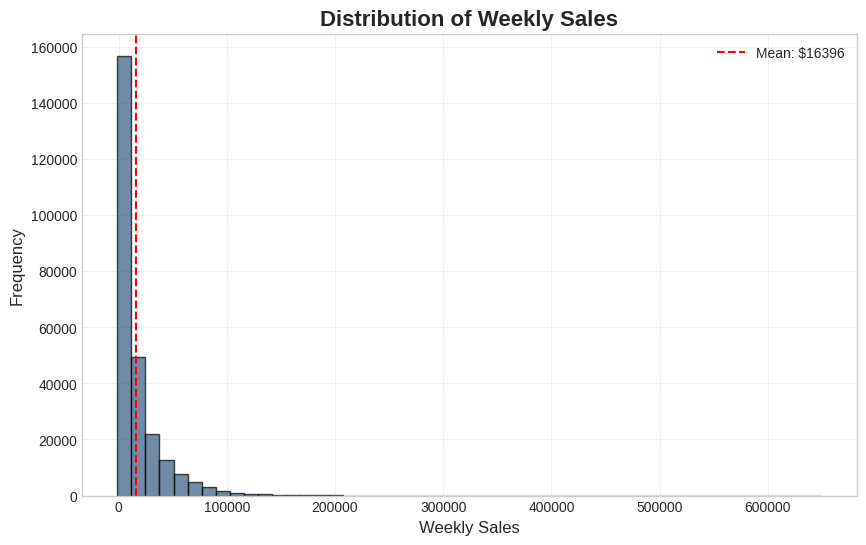

In [ ]:
colors = ['#355a81', '#816335', '#81355a', '#5a8135']

# Set the plot style and size
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))

# 1. Sales distribution histogram
plt.hist(df['Weekly_Sales'], bins=50, alpha=0.7, color=colors[0], edgecolor='black')
plt.title('Distribution of Weekly Sales', fontweight='bold', fontsize=16)
plt.xlabel('Weekly Sales', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(df['Weekly_Sales'].mean(), color='red', linestyle='--',
            label=f'Mean: ${df["Weekly_Sales"].mean():.0f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Most weekly sales are small, but there are a few very large sales

**2. Monthly Seasonality Pattern**

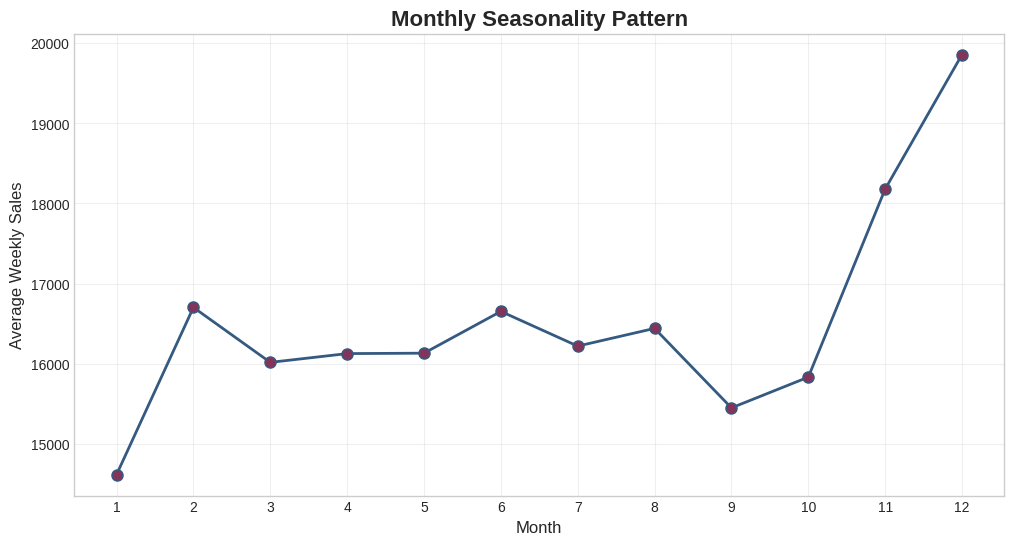

In [ ]:
# Set the plot size
plt.figure(figsize=(12, 6))

# 2. Calculate and plot monthly seasonality
monthly_avg = df.groupby('Month')['Weekly_Sales'].mean()
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2,
         markersize=8, color=colors[0], markerfacecolor=colors[2])
plt.title('Monthly Seasonality Pattern', fontweight='bold', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Weekly Sales', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 13))
plt.show()

Most weekly sales are small, but there are a few very large sales

**3.Holiday Impact on Sales**

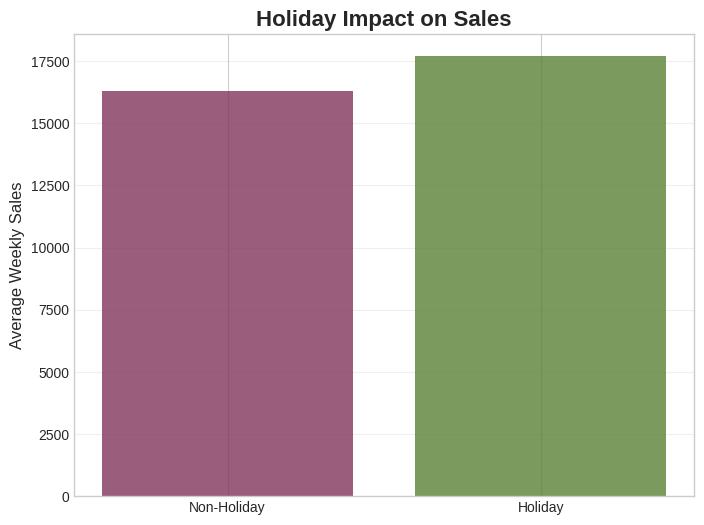

In [ ]:
# Set the plot size
plt.figure(figsize=(8, 6))

# 3. Calculate and plot holiday impact
holiday_avg = df.groupby('IsHoliday')['Weekly_Sales'].mean()
plt.bar(['Non-Holiday', 'Holiday'], holiday_avg.values,
        color=[colors[2], colors[3]], alpha=0.8)
plt.title('Holiday Impact on Sales', fontweight='bold', fontsize=16)
plt.ylabel('Average Weekly Sales', fontsize=12)
plt.grid(True, which='major', axis='y', alpha=0.3)
plt.show()

Sales are noticeably higher during holiday weeks. This makes the 'IsHoliday' feature very important for our model.

**4.Sales Trend with Rolling Average**

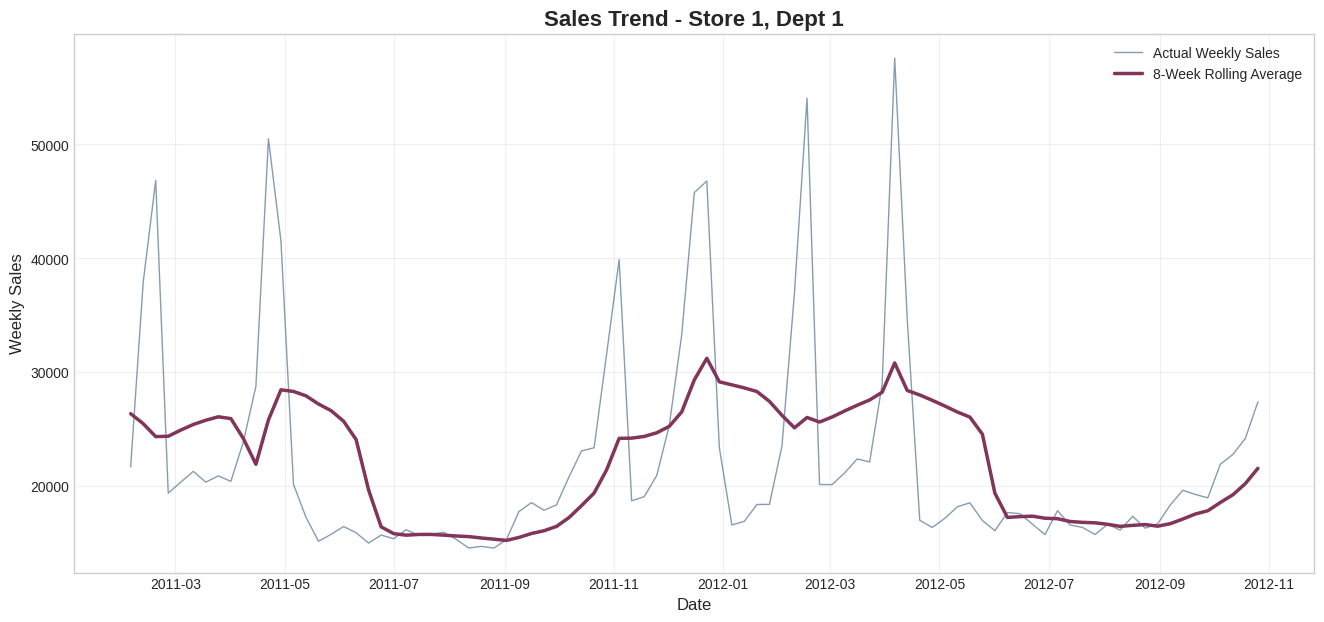

In [ ]:
# Set the plot size
plt.figure(figsize=(16, 7))

# 4. Plot sales trend for a sample store/department
sample_store = df[(df['Store'] == 1) & (df['Dept'] == 1)].set_index('Date')
if len(sample_store) > 0:
    sample_store = sample_store.sort_index()
    # Note: The 'Rolling_8' column was already created in your feature engineering step

    plt.plot(sample_store.index, sample_store['Weekly_Sales'],
             alpha=0.6, label='Actual Weekly Sales', linewidth=1, color=colors[0])
    plt.plot(sample_store.index, sample_store['Rolling_8'],
             color=colors[2], linewidth=2.5, label='8-Week Rolling Average')
    plt.title('Sales Trend - Store 1, Dept 1', fontweight='bold', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Weekly Sales', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

By averaging the sales over the last 8 weeks, we get a clearer, more stable view of the sales performance (purple line) than just looking at the volatile weekly sales (blue line).


**5.Year-over-Year Comparison**

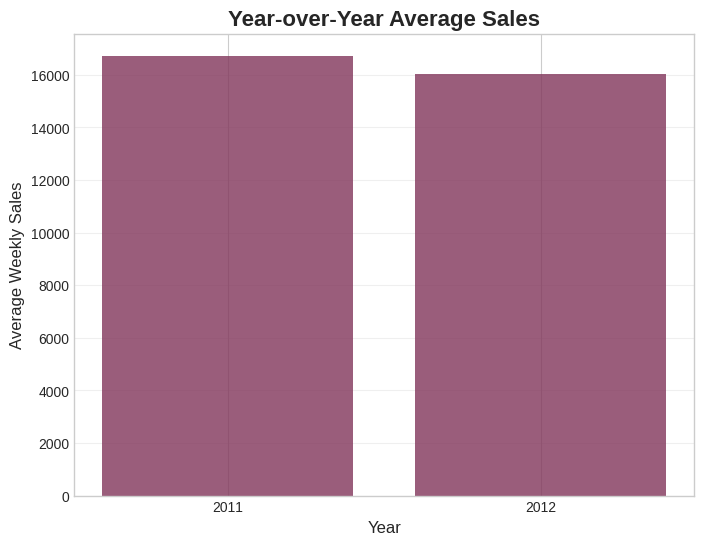

In [ ]:
# Set the plot size
plt.figure(figsize=(8, 6))

# 5. Calculate and plot year-over-year comparison
yearly_sales = df.groupby('Year')['Weekly_Sales'].mean()
plt.bar(yearly_sales.index, yearly_sales.values, color=colors[2], alpha=0.8)
plt.title('Year-over-Year Average Sales', fontweight='bold', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Weekly Sales', fontsize=12)
plt.xticks(yearly_sales.index)
plt.grid(True, which='major', axis='y', alpha=0.3)
plt.show()

sales were highest in 2011

**6.Sales by Store Type**

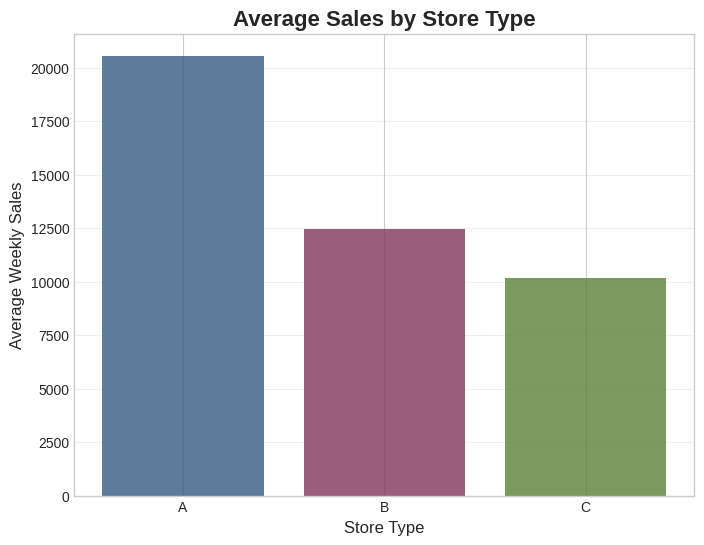

In [ ]:
# Set the plot size
plt.figure(figsize=(8, 6))

# 6. Calculate and plot sales by store type
store_type_sales = df.groupby('Type')['Weekly_Sales'].mean()
plt.bar(store_type_sales.index, store_type_sales.values,
        color=[colors[0], colors[2], colors[3]], alpha=0.8)
plt.title('Average Sales by Store Type', fontweight='bold', fontsize=16)
plt.xlabel('Store Type', fontsize=12)
plt.ylabel('Average Weekly Sales', fontsize=12)
plt.xticks(ticks=[0, 1, 2], labels=['A', 'B', 'C']) # Use original labels
plt.grid(True, which='major', axis='y', alpha=0.3)
plt.show()

Type 'A' stores sell the most, followed by 'B', and then 'C'. Store type is a strong predictor of sales.

In [ ]:

# Monthly averages
monthly_avg = df.groupby('Month')['Weekly_Sales'].mean()
# Holiday averages
holiday_avg = df.groupby('IsHoliday')['Weekly_Sales'].mean()
# Yearly averages
yearly_sales = df.groupby('Year')['Weekly_Sales'].mean()
# Store Type averages
store_type_sales = df.groupby('Type')['Weekly_Sales'].mean()


print("SEASONAL ANALYSIS SUMMARY\n")

# Strongest and weakest months
print(f" Strongest month: Month {monthly_avg.idxmax()} (${monthly_avg.max():.2f})")
print(f" Weakest month: Month {monthly_avg.idxmin()} (${monthly_avg.min():.2f})")

# Holiday boost percentage
holiday_boost_pct = ((holiday_avg[1] / holiday_avg[0]) - 1) * 100
print(f" Holiday boost: {holiday_boost_pct:.1f}%")

# Best performing year
print(f" Best performing year: {yearly_sales.idxmax()} (${yearly_sales.max():.2f})")

# Best performing store type
print(f" Best performing store type: Type {store_type_sales.idxmax()} (${store_type_sales.max():.2f})")

# Optional: Add the monthly variation insight as well
monthly_variation_pct = ((monthly_avg.max() - monthly_avg.min()) / monthly_avg.min()) * 100
print(f" Monthly variation: {monthly_variation_pct:.1f}% difference between highest and lowest months")

SEASONAL ANALYSIS SUMMARY

 Strongest month: Month 12 ($19857.33)
 Weakest month: Month 1 ($14616.09)
 Holiday boost: 8.5%
 Best performing year: 2011 ($16729.24)
 Best performing store type: Type 0 ($20561.38)
 Monthly variation: 35.9% difference between highest and lowest months


# Data Splitting

In [ ]:
# Define the target variable
TARGET = 'Weekly_Sales'

# Define features
features = [col for col in df.columns if col not in ['Date', TARGET]]

# Separate features (X) and target (y)
X = df[features]
y = df[TARGET]

# Time-based data split
# We'll use the last 6 months of data as the test set
split_date = df['Date'].max() - pd.DateOffset(months=6)
train_idx = df[df['Date'] <= split_date].index
test_idx = df[df['Date'] > split_date].index

# Create training and testing sets
X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

# Display dataset shapes
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Training set shape: (182708, 32)
Testing set shape: (78375, 32)


- **Define Target**:  Weekly_Sales is the variable we want to predict (this is y).
- **Define Features**: All other columns are the information the model will use to make its prediction (this is X).
- **Time-Based Split**: we don't split the data randomly. We train the model on all the older data and keep the last 6 months as a "final exam" to test its performance.

# Model Training

In [ ]:
# Create and train the model
# These hyperparameters can be adjusted to improve performance (Hyperparameter Tuning)
model = xgb.XGBRegressor(
    n_estimators=1000,           # Number of trees in the model
    learning_rate=0.05,          # Learning rate (controls how fast the model learns)
    max_depth=7,                 # Maximum depth of each tree (controls model complexity)
    subsample=0.8,               # Fraction of samples used to build each tree
    colsample_bytree=0.8,        # Fraction of features used to build each tree
    objective='reg:squarederror',# Objective function (minimize squared error)
    n_jobs=-1,                   # Use all CPU cores to speed up training
    random_state=42              # Ensures reproducible results
)

# Train the model with Early Stopping
# This prevents overfitting by stopping training when performance stops improving
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='rmse',
          early_stopping_rounds=50,  # Stop if RMSE does not improve for 50 rounds
          verbose=100)               # Print progress every 100 rounds


[0]	validation_0-rmse:21940.56720	validation_1-rmse:21000.42373
[100]	validation_0-rmse:1714.41830	validation_1-rmse:1717.15461
[184]	validation_0-rmse:1351.68400	validation_1-rmse:1687.25772


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

**Training Insight**
- The training log shows the model learned very effectively. The error on the test set (validation_1-rmse) dropped sharply from over 21,000  to its best point around 1,687. Crucially, the training stopped automatically at round 184 thanks to early stopping. This is the ideal outcome, as it prevents the model from overfitting and ensures it generalizes well for making accurate future predictions.

# Model Evaluation

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)             # Mean Absolute Error: average absolute difference between actual and predicted values
rmse = np.sqrt(mean_squared_error(y_test, y_pred))    # Root Mean Squared Error: penalizes larger errors more heavily

# Display evaluation results
print("MODEL EVALUATION")
print(f" Mean Absolute Error (MAE): ${mae:,.2f}")
print(f" Root Mean Squared Error (RMSE): ${rmse:,.2f}")


MODEL EVALUATION
 Mean Absolute Error (MAE): $763.70
 Root Mean Squared Error (RMSE): $1,681.95


The model sales predictions are only off by about $763

# Actual vs. Predicted Plot

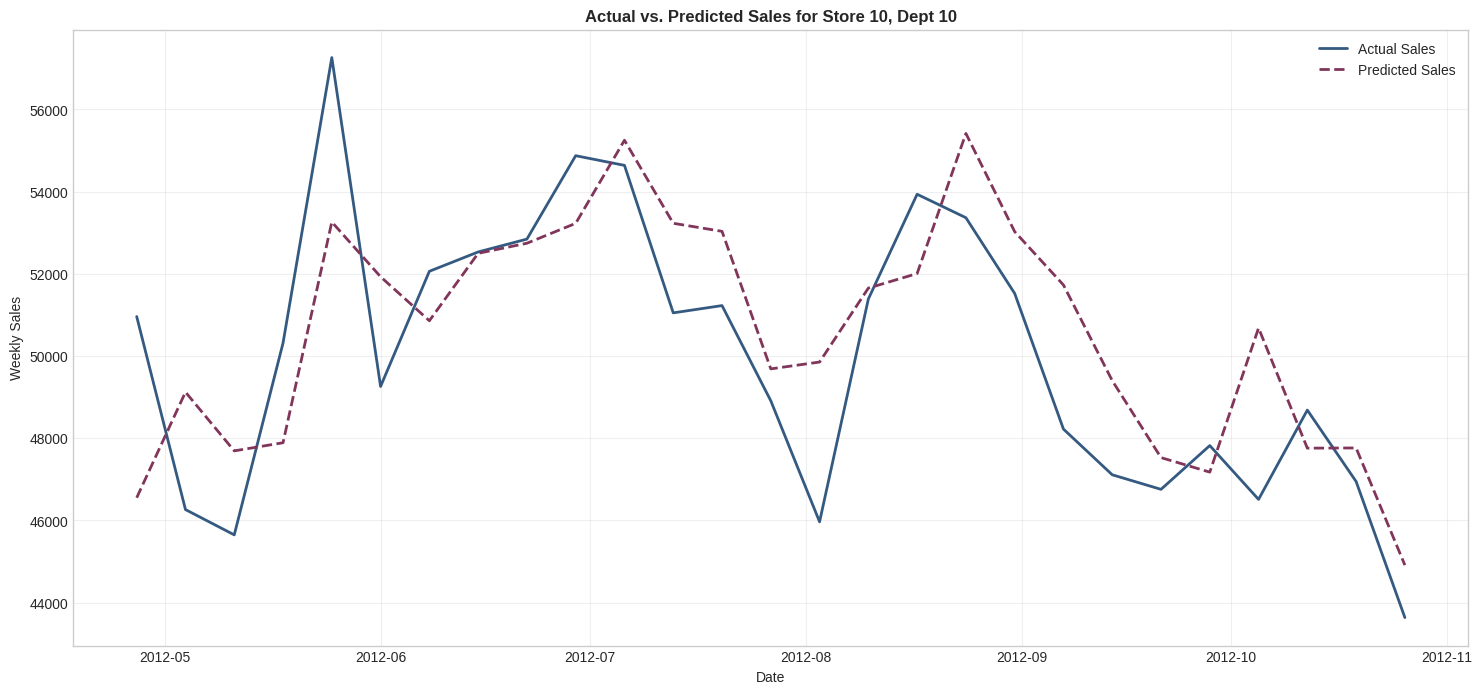

In [ ]:
# Create a DataFrame to compare actual and predicted sales
results = pd.DataFrame({
    'Date': df.loc[test_idx, 'Date'],
    'Store': df.loc[test_idx, 'Store'],
    'Dept': df.loc[test_idx, 'Dept'],
    'Actual_Sales': y_test,
    'Predicted_Sales': y_pred
})

# Select one specific store and department to visualize
sample_results = results[(results['Store'] == 10) & (results['Dept'] == 10)].copy()

# Plot actual vs predicted sales for the chosen store and department
plt.figure(figsize=(18, 8))
plt.plot(sample_results['Date'], sample_results['Actual_Sales'], label='Actual Sales', color=colors[0], lw=2)
plt.plot(sample_results['Date'], sample_results['Predicted_Sales'], label='Predicted Sales', color=colors[2], linestyle='--', lw=2)
plt.title('Actual vs. Predicted Sales for Store 10, Dept 10', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Feature Importance Plot

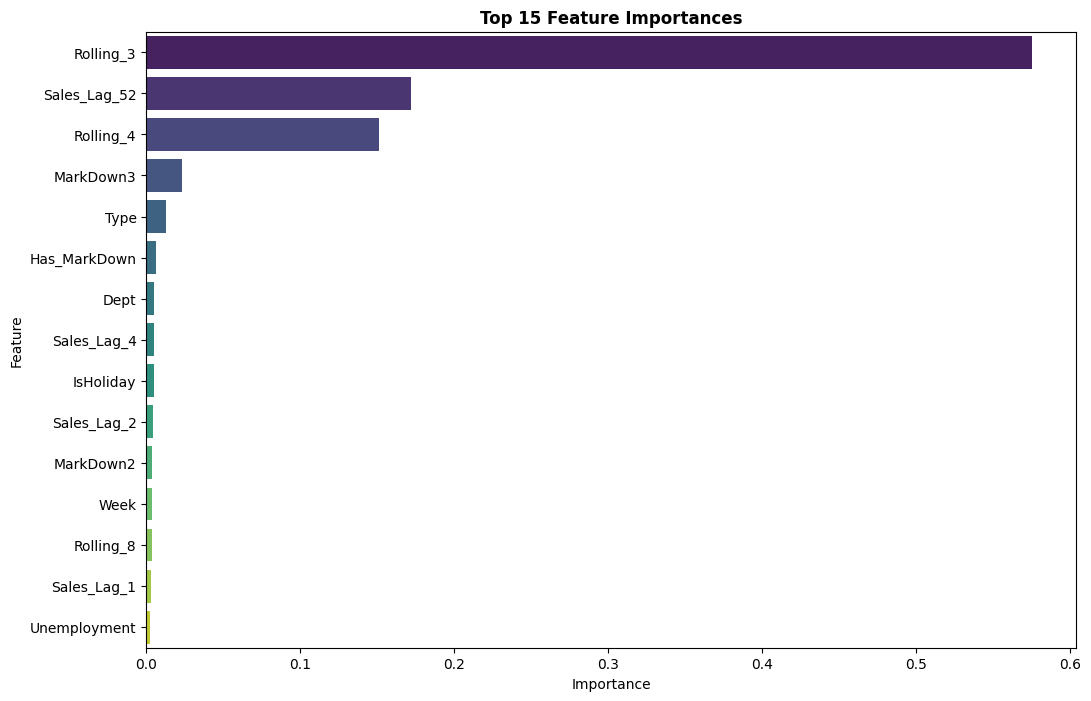

In [ ]:
# Display the top 15 most important features
feature_importance = pd.DataFrame({
    'Feature': model.feature_names_in_,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

# Visualize feature importance using a horizontal bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Top 15 Feature Importances', fontweight='bold')
plt.show()


This chart shows the model's most important clues. The best clues were the average of recent sales (Rolling_3) and sales from the same week last year (Sales_Lag_52).
